In [1]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 25.8 MB/s eta 0:00:00:00:0100:01


In [2]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
import json
# Add additional imports for visualization
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List
from torch.nn import CrossEntropyLoss
import math
# Set environment variables for better memory management
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
torch.cuda.empty_cache()

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.training_metrics = {
            'loss': [],
            'perplexity': [],
            'steps': []
        }

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        logits = outputs.logits
        labels = inputs['labels']
        
        # Shift logits and labels for next token prediction
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        
        # Calculate perplexity
        perplexity = math.exp(loss.item())
        
        if not return_outputs:
            return loss
        
        return (loss, {'loss': loss, 'perplexity': perplexity})

    def training_step(self, *args, **kwargs):
        loss = super().training_step(*args, **kwargs)
        perplexity = math.exp(loss.item())
        
        self.training_metrics['loss'].append(loss.item())
        self.training_metrics['perplexity'].append(perplexity)
        self.training_metrics['steps'].append(len(self.training_metrics['loss']))
        
        return loss

In [3]:
# Load and prepare the dataset
with open('/kaggle/input/ielts-dataset/dataset.json', 'r') as f:
    raw_data = json.load(f)

# Format data with clear separation tokens
formatted_data = [{
    'text': f"<s>[INST] {item['instruction']} [/INST] {item['response']} </s>"
} for item in raw_data]

from datasets import Dataset
dataset = Dataset.from_list(formatted_data)

In [4]:
# Load model and tokenizer with optimized settings
model_name = "/kaggle/input/llama-3.2/transformers/1b-instruct/1"
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='right')
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    use_cache=False,
    device_map='auto',  # Enable automatic device mapping
    low_cpu_mem_usage=True
)

# Ensure proper tokenizer settings
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    return tokenizer(
        examples['text'],  # Changed from 'input_text' to 'text'
        truncation=True,
        max_length=1024,  # Reduced from 512 to save memory
        padding='max_length',
        return_tensors=None  # Important: let the data collator handle this
    )

# Prepare the dataset
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text']  # Changed from dataset.column_names to ['text']
)

Map:   0%|          | 0/279 [00:00<?, ? examples/s]

In [5]:
# Updated DataCollator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=8
)

# Updated training arguments without evaluation
training_args = TrainingArguments(
    output_dir="./ielts_llama_finetuned",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    bf16=True,
    save_steps=50,
    logging_steps=10,
    save_total_limit=1,
    max_grad_norm=1.0,
    gradient_checkpointing=True,
    report_to="none",
    remove_unused_columns=False,
    seed=42,
    evaluation_strategy="no", 
    optim="adamw_torch",
    dataloader_pin_memory=False,
    dataloader_num_workers=0,
    ddp_find_unused_parameters=False
)

# Initialize custom trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [6]:
# Start training and visualization
train_result = trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss
10,1.895300
20,0.995700
30,0.564200
40,0.433600
50,0.391100


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


In [7]:
trainer.save_model("./ielts_llama_final")

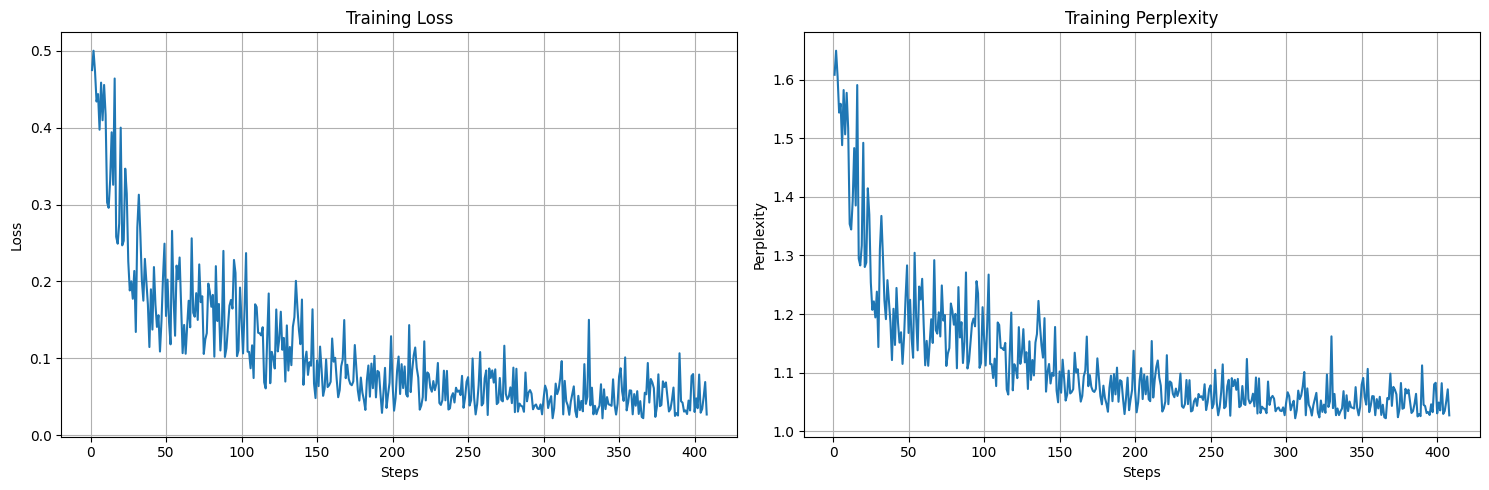

Final training metrics:
Average loss: 0.1058
Final loss: 0.0269
Average perplexity: 1.1163
Final perplexity: 1.0273


In [9]:
# Plot training metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(trainer.training_metrics['steps'], trainer.training_metrics['loss'])
ax1.set_title('Training Loss')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Plot perplexity
ax2.plot(trainer.training_metrics['steps'], trainer.training_metrics['perplexity'])
ax2.set_title('Training Perplexity')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Perplexity')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print("Final training metrics:")
print(f"Average loss: {np.mean(trainer.training_metrics['loss']):.4f}")
print(f"Final loss: {trainer.training_metrics['loss'][-1]:.4f}")
print(f"Average perplexity: {np.mean(trainer.training_metrics['perplexity']):.4f}")
print(f"Final perplexity: {trainer.training_metrics['perplexity'][-1]:.4f}")